# 📈 Pairs Trading
- Pairs trading (**mean reversion**) strategy relies on finding stationarity between a pair of stocks
- Long pair -> go long on stock A and short on stock B
- Short pair -> go short on stock A and long on stock B
- Effectively you want to find a high correlation (coindependence, > 0.8) between stock A and stock B and capitalise on when they move in opposite directions.
- Once the assets deviate from their typical correlation (i.e. 0.5 but more specifically by some number of standard deviations (e.g., ±2σ) from its mean) you can long/short the pair since you expect the correlation to converge back to the original state.
- Co-integration is more important than just correlation, because it ensures a stable spread between the two assets that will revert over time.
- Ideally, pairs are from the same sector/industry to reduce the chance of structural breaks.

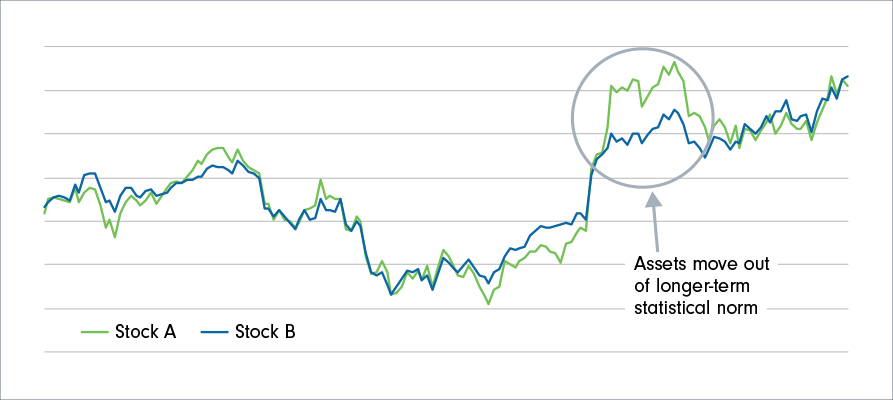

## Find a Pair

Firstly, you need to find two assets that move similarly with eachother (whether it be a positive or negative correlation)

In [70]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime

START_DATE = datetime(2020, 4, 24)
END_DATE = datetime(2021, 4, 24)

def get_historical_stock_data(tickers: list[str]) -> pd.DataFrame:
    data = pd.DataFrame()
    for ticker in tickers:
        adj_close = yf.download(ticker, start=START_DATE, end=END_DATE, auto_adjust=True, progress=False)["Close"]
        data[ticker] = adj_close
    return data

tickers = ["DPZ", "AAPL", "GOOG", "AMD", "GME", "SPY", "NFLX", "BA", "WMT","GS","XOM","NKE","BRK-B", "MSFT", "COST", "XOM", "CVX"]

df = get_historical_stock_data(tickers)

print(f"Shape: {df.shape}")
df.tail()

Shape: (252, 16)


,DPZ,AAPL,GOOG,AMD,GME,SPY,NFLX,BA,WMT,GS,XOM,NKE,BRK-B,MSFT,COST,CVX
Date,,,,,,,,,,,,,,,,
2021-04-19,377.489899,131.583893,114.439751,81.110001,41.092499,391.088470,554.440002,244.149994,43.781261,307.377014,47.356216,124.493904,270.279999,249.308853,350.845123,85.617210
2021-04-20,377.575256,129.895660,114.003853,79.269997,39.632500,388.224976,549.570007,234.059998,44.119705,297.333832,46.358456,119.366524,267.890015,248.846420,352.914764,84.016960
2021-04-21,374.492493,130.276230,113.986946,81.610001,39.627499,391.898529,508.899994,235.919998,44.248184,300.370941,46.953770,121.986557,272.209991,251.081787,355.155334,85.177773
2021-04-22,378.248810,128.753906,112.725937,79.059998,37.792500,388.319244,508.779999,234.330002,43.768730,296.411041,46.341679,121.310417,269.510010,247.796112,352.468689,83.701897
2021-04-23,377.252716,131.076462,115.080940,82.760002,37.794998,392.529633,505.549988,238.380005,43.840794,304.026337,46.593220,122.258904,271.980011,251.631027,354.386292,84.199379


<Axes: >

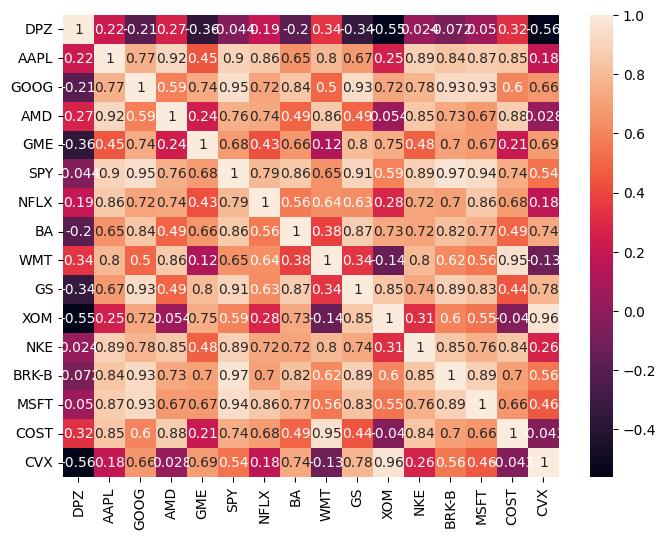

In [71]:
import seaborn as sn
from matplotlib.pyplot import figure

# calculate and visualise correlation between stock closing prices (adjusted)
corr_matrix = df.corr()

figure(figsize=(8, 6), dpi=100)
sn.heatmap(corr_matrix, annot=True)

In [72]:
# find pair with highest correlation (excluding self-correlation)
# mask the diagonal
mask = ~np.eye(corr_matrix.shape[0], dtype=bool)
corr_matrix_values = corr_matrix.where(mask)

# unstack and find the max
max_corr = corr_matrix_values.unstack().sort_values(ascending=False).dropna().head(1)
print("Highest correlated pair:\n", max_corr)

Highest correlated pair:
 SPY  BRK-B    0.968449
dtype: float64


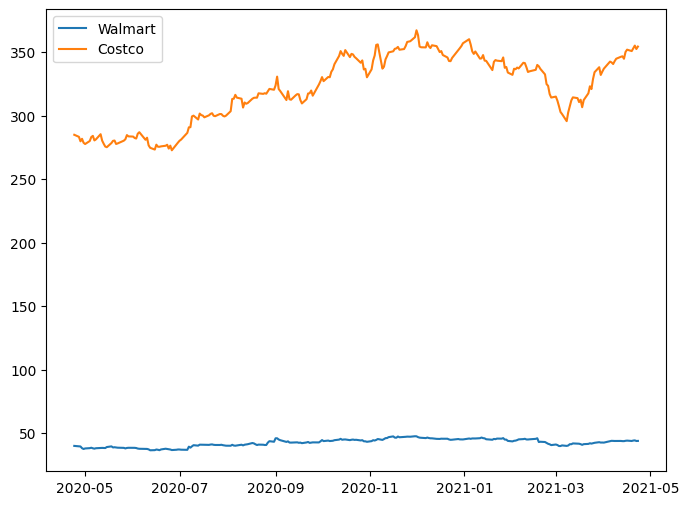

In [73]:
import matplotlib.pyplot as plt
figure(figsize=(8, 6), dpi=100)
WMT = df['WMT'] # Walmart
COST = df['COST'] # Costco

plt.plot(WMT, label = "Walmart")
plt.plot(COST, label = "Costco")
plt.legend()

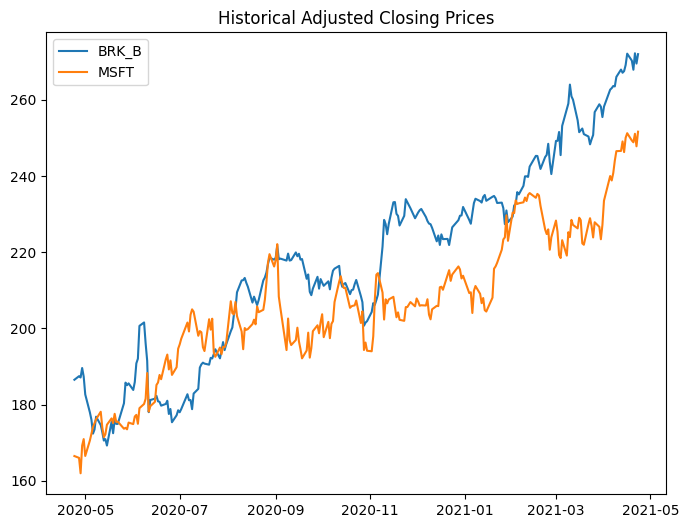

In [74]:
figure(figsize=(8, 6), dpi=100)
BRK_B = df['BRK-B']
MSFT = df['MSFT']
plt.plot(BRK_B, label = "BRK_B")
plt.plot(MSFT, label = "MSFT")
plt.title('Historical Adjusted Closing Prices')
plt.legend()

Text(0.5, 1.0, 'Spread between BRK-B and MSFT')

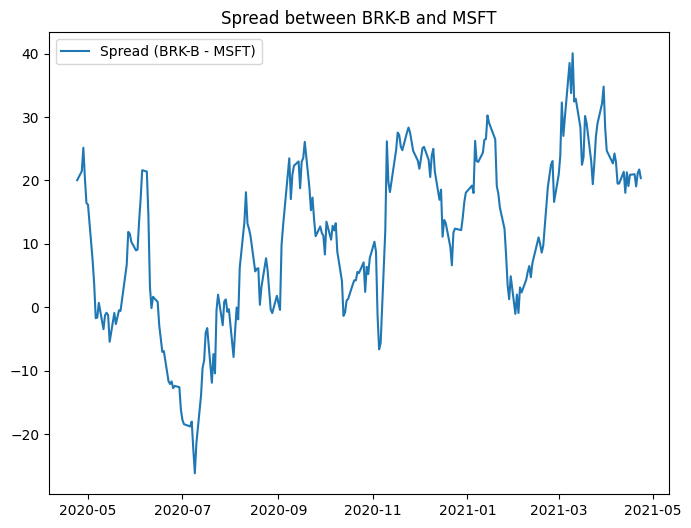

In [75]:
# plot the spread (i.e. difference between two stocks)
figure(figsize=(8, 6), dpi=100)
plt.plot(BRK_B - MSFT, label = 'Spread (BRK-B - MSFT)')
plt.legend()
plt.title("Spread between BRK-B and MSFT")

In [76]:
# Check out the cointegration value: Null hyp. = no cointegration
import statsmodels.tsa.stattools as ts 
result = ts.coint(BRK_B, MSFT)

# Cointegration test: A technique used to find a potential correlation in a time series (long term)
# Determines if the spread between the two assets are constant over time.
# Null Hypothesis: Spread between series are non-stationary.
# Uses the augmented Engle-Granger two-step cointegration test.
cointegration_t_statistic = result[0]
p_val = result[1]
critical_values_test_statistic_at_1_5_10 = result[2]
print('We want the P val < 0.05 (meaning that cointegration exists)')
print('P value for the augmented Engle-Granger two-step cointegration test is', p_val)

We want the P val < 0.05 (meaning that cointegration exists)
P value for the augmented Engle-Granger two-step cointegration test is 0.0648356946773062


In [77]:
from statsmodels.tsa.stattools import adfuller
# Compute the ADF test for Berkshire Hathaway and Microsoft
# With all time series, you want to have stationary data otherwise our data will be very hard to predict.
# ADF for Berkshire Hathaway Class B
BRK_B_ADF = adfuller(BRK_B)
print('P value for the Augmented Dickey-Fuller Test is', BRK_B_ADF[1])
MSFT_ADF = adfuller(MSFT)
print('P value for the Augmented Dickey-Fuller Test is', MSFT_ADF[1])
Spread_ADF = adfuller(BRK_B - MSFT)
print('P value for the Augmented Dickey-Fuller Test is', Spread_ADF[1])
Ratio_ADF = adfuller(BRK_B / MSFT)
print('P value for the Augmented Dickey-Fuller Test is', Ratio_ADF[1])
# Spread looks fine. If you'd want even better results, consider taking the difference (order 1) of Berkshire and MSFT

# Results: can only claim stationary for the spread (since P value < 0.05). This suggests a constant mean over time.
# Therefore, the two series are cointegrated.

P value for the Augmented Dickey-Fuller Test is 0.9078709187914542
P value for the Augmented Dickey-Fuller Test is 0.7145872645725287
P value for the Augmented Dickey-Fuller Test is 0.06460926195012998
P value for the Augmented Dickey-Fuller Test is 0.03200762905352228


Text(0.5, 1.0, 'Price Ratio between BRK and MSFT')

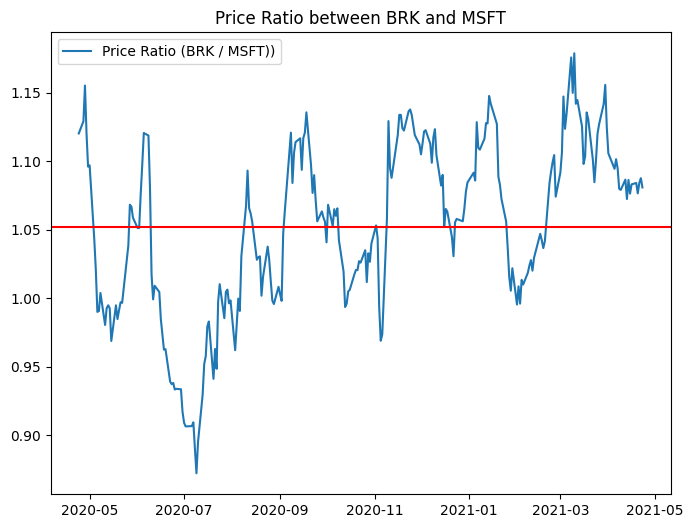

In [79]:
# Also, we can take a look at the price ratios between the two time series.
figure(figsize=(8, 6), dpi=100)
ratio = BRK_B / MSFT
plt.plot(ratio, label = 'Price Ratio (BRK / MSFT))')
plt.axhline(ratio.mean(), color='red')
plt.legend()
plt.title("Price Ratio between BRK and MSFT")

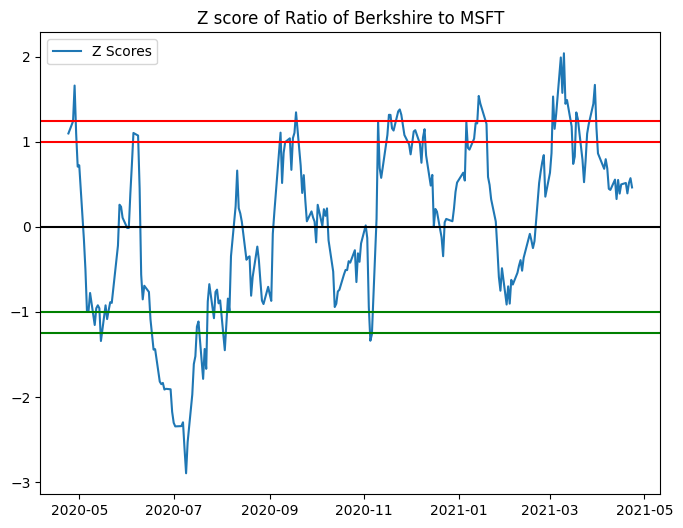

In [81]:
# NOTE, here you can either use the spread OR the Price ratio approach. Anyways, let's standardize the ratio so we can have a 
# upper and lower bound to help evaluate our trends.. Let's stick with the ratio data.
figure(figsize=(8, 6), dpi=100)
# Calculate the Zscores of each row.
df_zscore = (ratio - ratio.mean())/ratio.std()
plt.plot(df_zscore, label = "Z Scores")
plt.axhline(df_zscore.mean(), color = 'black')
plt.axhline(1.0, color='red') # Setting the upper and lower bounds to be the z score of 1 and -1 (1/-1 standard deviation)
plt.axhline(1.25, color='red') # 95% of our data will lie between these bounds.
plt.axhline(-1.0, color='green') # 68% of our data will lie between these bounds.
plt.axhline(-1.25, color='green') # 95% of our data will lie between these bounds.
plt.legend(loc = 'best')
plt.title('Z score of Ratio of Berkshire to MSFT')
plt.show()
# For the most part, the range that exists outside of these 'bands' must come converge back to the mean. Thus, you can 
# determine when you can go long or short the pair (BRK_B to MSFT).

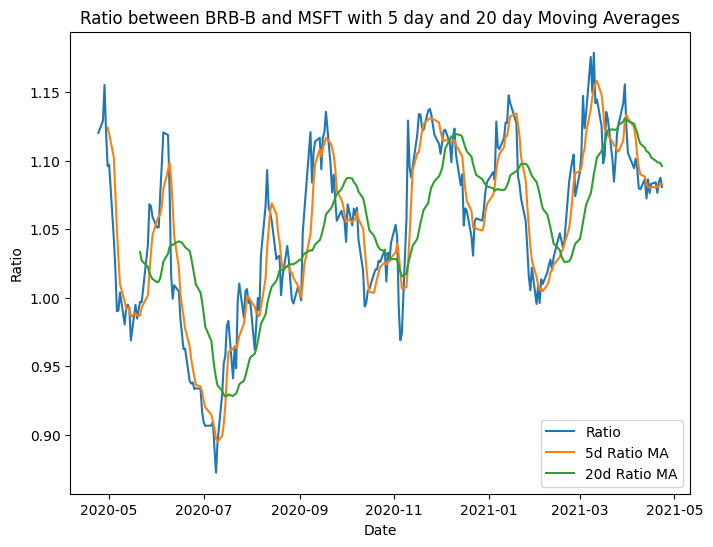

In [83]:
figure(figsize=(8, 6), dpi=100)
ratios_mavg5 = ratio.rolling(window=5, center=False).mean()
ratios_mavg20 = ratio.rolling(window=20, center=False).mean()
std_20 = ratio.rolling(window=20, center=False).std()
zscore_20_5 = (ratios_mavg5 - ratios_mavg20)/std_20
plt.plot(ratio.index, ratio.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg20.index, ratios_mavg20.values)
plt.legend(['Ratio', '5d Ratio MA', '20d Ratio MA'])
plt.xlabel('Date')
plt.ylabel('Ratio')
plt.title('Ratio between BRB-B and MSFT with 5 day and 20 day Moving Averages')
plt.show()

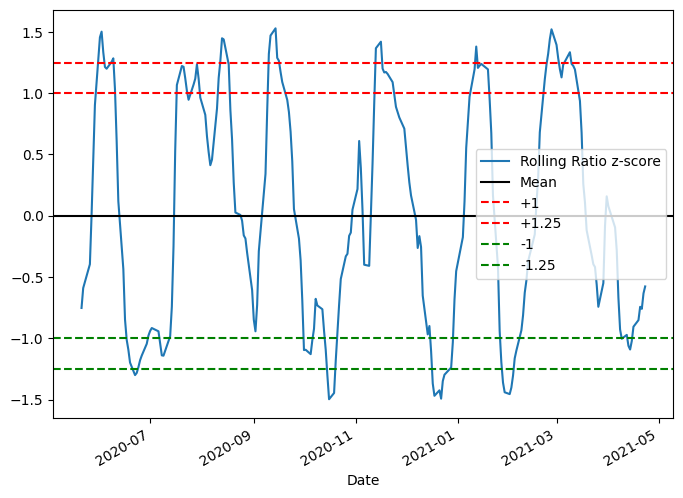

In [86]:
figure(figsize=(8, 6), dpi=100)
zscore_20_5.plot()
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(1.25, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')
plt.axhline(-1.25, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-score', 'Mean', '+1','+1.25','-1','-1.25'])
plt.show()

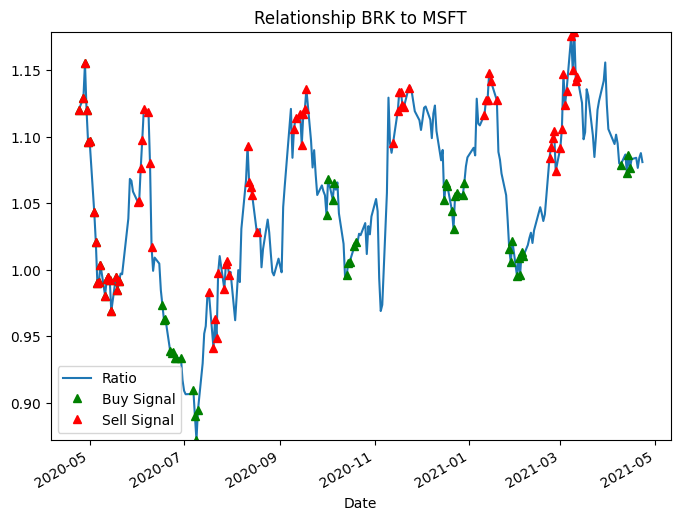

In [87]:
figure(figsize=(8, 6), dpi=100)
ratio.plot()
buy = ratio.copy()
sell = ratio.copy()
buy[zscore_20_5>-1] = 0
sell[zscore_20_5<1] = 0
buy.plot(color='g', linestyle='None', marker='^')
sell.plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratio.min(), ratio.max()))
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.title('Relationship BRK to MSFT')
plt.show()